In [ ]:
pip install matplotlib numpy ipywidgets ipympl

# Linear Programming
Linear Programming (LP) is a family of algorithms used to maximise a linear function under a set of linear constraints. For example:

Maximise \
$\hspace{2em}f(x_1, x_2) = 3x_1 + 5x_2$

Subject to constraints: \
$\hspace{2em}x_1 + 2x_2 \leq 5$ \
$\hspace{2em}3x_1 + x_2 \leq 5$ \
$\hspace{2em}3x_1 + 2x_2 \leq 6$ \
$\hspace{2em}x_1, x_2 \geq 0$

This form of optimisation problems occur in everyday life frequently. For example:
> Suppose a company manufactures two products A and B that requires the same type but different amount of resources like raw materials, labour hours and machine hours. Each product has its own pricing. The company wishes to maximise their revenue with constraints on those resources.

We can formulate this example into an LP problem. Let $p_a$, $r_a$, $l_a$ and $m_a$ represent the profit, raw materials, labour hours and machine hours for a product A, and similarly for product B. Let $x_a$ be the number of units of A to produce and similarly for B.

Maximise: \
$\hspace{2em}Z = p_a x_a + p_b x_b$

Subject to constraints: \
$\hspace{2em}r_a x_a + r_b x_b \leq R$ \
$\hspace{2em}l_a x_a + l_b x_b \leq L$ \
$\hspace{2em}m_a x_a + m_b x_b \leq M$ \
$\hspace{2em}x_a, x_b \geq 0$

## Intuition
Let us consider the 2D example earlier:

Maximise \
$\hspace{2em}f(x_1, x_2) = 3x_1 + 5x_2$

Subject to constraints: \
$\hspace{2em}x_1 + 2x_2 \leq 5$ \
$\hspace{2em}3x_1 + x_2 \leq 5$ \
$\hspace{2em}3x_1 + 2x_2 \leq 6$ \
$\hspace{2em}x_1, x_2 \geq 0$

Let's try to visualise the constraints with a graph:

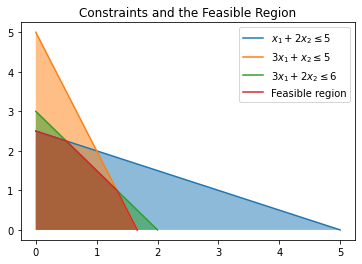

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

def plot(ax, x1, x2, label, fill):
    ax.plot(x1, x2, label=label)
    if fill: ax.fill_between(x1, x2, np.zeros(x2.shape), alpha=0.5)

def plot_line(ax, c1, c2, k, label, fill):
    x1 = np.array([0, k / c1])
    x2 = np.array([k / c2, 0])
    plot(ax, x1, x2, label, fill)

fig, ax = plt.subplots()

plot_line(ax, 1, 2, 5, "$x_1+2x_2\leq5$", True)
plot_line(ax, 3, 1, 5, "$3x_1+x_2\leq5$", True)
plot_line(ax, 3, 2, 6, "$3x_1+2x_2\leq6$", True)

# Compute line intersections for feasible region
x1 = np.array([0, 0.5, 1.333333, 1.666667])
x2 = np.array([2.5, 2.25, 1, 0])
plot(ax, x1, x2, "Feasible region", True)

plt.title("Constraints and the Feasible Region")
plt.legend()
plt.show()

Each inequality constraint is graphically known as a **half-region**. The intersection of all these half-regions is a **polytope** depicting the **feasible region**, where the **decision variables** $(x_1, x_2)$ satisifies the constraints that have been imposed and thus are **feasible solutions**.

Given that the objective function is linear, we can visualise geometrically that the optimal solution must lie in one of the corners of the feasible region. The solutions at the corners are termed as **basic feasible solutions (BFS)**.

In 2D, we can simply use a graphical method as above:
1) Compute the corners of the feasible region.
2) Compute the value of the objective function at each corner.
3) Choose the corner that gives the maximum value for the objective function.

However, in higher dimensions and increasing number of constraints, the computation of the feasible region becomes increasingly expensive:
- If we have $N$ constraints, adding another constraint will require additional $N$ computations for intersections with other constraints, then checking if this new intersection is a valid BFS.
- Increasing the number of dimensions greatly increases the number of computations and complexity required to solve for the intersection between higher dimensional half-spaces.

## Dantzig's Simplex Algorithm
We will use the simplex algorithm to work through the example above and explain along the way.

#### STEP 1: Introduction of slack variables
Let us introduce variables to transform the inequality constraints into equality constraints:

$\hspace{2em}x_1 + 2x_2 + s_1 = 5$ \
$\hspace{2em}3x_1 + x_2 + s_2 = 5$ \
$\hspace{2em}3x_1 + 2x_2 + s_3 = 6$ \
$\hspace{2em}x_1, x_2, s_1, s_2, s_3 \geq 0$

These new variables $(s_1, s_2, s_3)$ are known as **slack variables**. Intuitively, they represent the unused potential of our constraint:
- If $s > 0$: The constraint is satisfied, but the decision variables can still be further increased.
- If $s = 0$: The constraint is satisfied and optimal. Increasing the decision variables any further will break the constraint.
- If $s < 0$: The constraint is broken.

Graphically, it can be interpreted as the distance of the constraint line from equality.

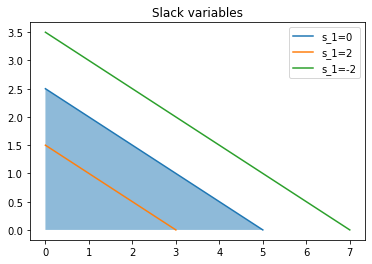

In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

def plot(ax, x1, x2, label, fill):
    ax.plot(x1, x2, label=label)
    if fill: ax.fill_between(x1, x2, np.zeros(x2.shape), alpha=0.5)

def plot_line(ax, c1, c2, k, label, fill):
    x1 = np.array([0, k / c1])
    x2 = np.array([k / c2, 0])
    plot(ax, x1, x2, label, fill)

# We will use the first constraint x_1 + 2x_2 + s_1 = 5 as our example
fig, ax = plt.subplots()

plot_line(ax, 1, 2, 5, "s_1=0", True)
plot_line(ax, 1, 2, 3, "s_1=2", False)
plot_line(ax, 1, 2, 7, "s_1=-2", False)
plt.legend()
plt.title("Slack variables")
plt.show()

#### STEP 2: Simplex Tableau
The transformation of inequalities to equalities is powerful in that it allows us to reformulate the expressions into a linear algebra problem:

\begin{equation}
\begin{bmatrix}
1 & 2 & 1 & 0 & 0 \\
3 & 1 & 0 & 1 & 0 \\
3 & 2 & 0 & 0 & 1 
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2 \\
s_1 \\
s_2 \\
s_3
\end{bmatrix}
=
\begin{bmatrix}
5 \\
5 \\
6
\end{bmatrix}
\end{equation}

We can also include the objective function $Z=3x_1+5x_2$ into the equation:

\begin{equation}
\begin{bmatrix}
1 & -3 & -5 & 0 & 0 & 0 \\
0 & 1 & 2 & 1 & 0 & 0 \\
0 & 3 & 1 & 0 & 1 & 0 \\
0 & 3 & 2 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
Z \\
x_1 \\
x_2 \\
s_1 \\
s_2 \\
s_3
\end{bmatrix}
=
\begin{bmatrix}
0 \\
5 \\
5 \\
6
\end{bmatrix}
\end{equation}

The above construction is an example of the **standard canonical form** for the simplex tableau:

\begin{equation}
\begin{bmatrix}
1 & -\textbf{c}^T & \textbf{0}^T \\
\textbf{0} & \textbf{A} & \textbf{I}
\end{bmatrix}
\begin{bmatrix}
Z \\
\textbf{x} \\
\textbf{s}
\end{bmatrix}
=
\begin{bmatrix}
0 \\
\textbf{b}
\end{bmatrix}
\end{equation}

#### Side notes
As we have noted earlier in STEP 1, the slack variable values can be interpreted as the distance from the constraint boundary. A value of 0 would mean a solution exactly at that boundary. **While fixing the value of a variable, changing other variables will simply mean moving along that boundary**. We term variables that are fixed to 0 as **non-basic variables (NBV)** and variables that are free as **basic variables (BV)**.

>The naming of basic variables derive from basis in a vector space. A basis is a set of linearly independent column vectors that defines a vector space. In the context of LP, solving a set of basic variables provides a unique solution (point in the feasible region). Non-basic variables are analogous to columns not in that basis. They are fixed to zero so that the system has a unique solution.

From a graphical perspective: **For a $D$ dimensional problem, each corner of the polytope is an intersection between $D$ constraints**. This means that at a corner, a $D$ number of constraints will be active, which translates to their corresponding slack variables to be 0.

In our example, there will be 2 NBVs and 3 BVs

#### STEP 3: The Simplex Algorithm
The simplex tableau method gives us a very nice initial feasible solution already by setting $x_1=x_2=0$ as our active constraints:
\begin{equation}
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
Z \\
s_1 \\
s_2 \\
s_3
\end{bmatrix}
=
\begin{bmatrix}
0 \\
5 \\
5 \\
6
\end{bmatrix}
\end{equation}

Solution: $(0, 0, 5, 5, 6) \rightarrow 0$

##### Entering variable
Now, in the first row, we can see that increasing $x_2$ will increase the value of $Z$, which means that maximising $x_2$ is equivalent to maximising $Z$. Thus, we choose $x_2$ as our **entering variable** (NBV to BV).

##### Leaving variable
When choosing the **leaving variable** (BV to NBV), we need to be mindful on which constraint will be the first to become active to ensure other constraints are not violated. Since we will be changing $x_2$ as our entering variable, we note which slack variable will be the first to become 0 as we increase $x_2$:
- $s_1=0 \rightarrow x_2=2.5$
- $s_2=0 \rightarrow x_2=5$
- $s_3=0 \rightarrow x_2=3$

The first to reach 0 while increasing $x_2$ is $s_1$, therefore we choose it as our leaing variable.

In matrix terms, we will pivot around column 3 row 2 which corresponds to switching the BV and NBV. For conciseness, we will be notating the equation in tableau format:
\begin{equation}
\begin{bmatrix}
\begin{array}{c|ccccc|c}
1 & -3 & -5 & 0 & 0 & 0 & 0 \\
\hline
0 & 1 & 2 & 1 & 0 & 0 & 5 \\
0 & 3 & 1 & 0 & 1 & 0 & 5 \\
0 & 3 & 2 & 0 & 0 & 1 & 6
\end{array}
\end{bmatrix}
\end{equation}

Pivoting and performing Gaussian elimination will yield us:
\begin{equation}
\begin{bmatrix}
\begin{array}{c|ccccc|c}
1 & -0.5 & 0 & 2.5 & 0 & 0 & 12.5 \\
\hline
0 & 0.5 & 1 & 0.5 & 0 & 0 & 2.5 \\
0 & 2.5 & 0 & -0.5 & 1 & 0 & 2.5 \\
0 & 2 & 0 & -1 & 0 & 1 & 1
\end{array}
\end{bmatrix}
\end{equation}

Next, we can see that increasing $x_1$ can still further increase the value of $Z$, so we choose it as the entering variable. Checking which variable should now be the leaving variable:
- $s_2=0 \rightarrow x_1=5$
- $s_2=0 \rightarrow x_1=1$
- $s_3=0 \rightarrow x_1=0.5$

So $s_3$ is our leaving variable.

\begin{equation}
\begin{bmatrix}
\begin{array}{c|ccccc|c}
1 & 0 & 0 & 2.25 & 0 & 0.25 & 12.75 \\
\hline
0 & 0 & 1 & 0.75 & 0 & -0.25 & 2.25 \\
0 & 0 & 0 & 0.75 & 1 & -1.25 & 1.25 \\
0 & 1 & 0 & -0.5 & 0 & 0.5 & 0.5
\end{array}
\end{bmatrix}
\end{equation}

With all the coefficients in the objective function being positive, increasing any variables will only reduce the objective value. Therefore, the optimal value has been reached.

The final solution is: $(0.5, 2.25)$ with a maximal value of 12.75.

### Graphical Interpretation


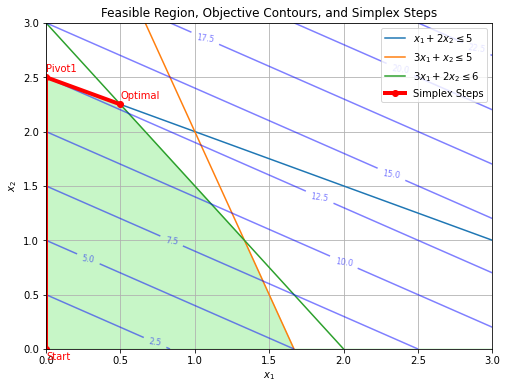

In [3]:
### Generated by GPT cuz ain't nobody got time for that

import numpy as np
import matplotlib.pyplot as plt

# 1. Define constraints
x1 = np.linspace(0, 3, 400)

c1 = (5 - x1)/2        # x1 + 2x2 <= 5
c2 = 5 - 3*x1           # 3x1 + x2 <= 5
c3 = (6 - 3*x1)/2       # 3x1 + 2x2 <= 6

# Feasible region
x2_feasible = np.minimum(np.minimum(c1, c2), c3)

# 2. Plot feasible region
plt.figure(figsize=(8,6))
plt.plot(x1, c1, label=r'$x_1 + 2x_2 \leq 5$')
plt.plot(x1, c2, label=r'$3x_1 + x_2 \leq 5$')
plt.plot(x1, c3, label=r'$3x_1 + 2x_2 \leq 6$')
plt.fill_between(x1, 0, x2_feasible, color='lightgreen', alpha=0.5)

# 3. Plot contour lines of Z = 3x1 + 5x2
X1, X2 = np.meshgrid(np.linspace(0,3,200), np.linspace(0,3,200))
Z = 3*X1 + 5*X2
contours = plt.contour(X1, X2, Z, levels=10, colors='blue', alpha=0.5)
plt.clabel(contours, inline=True, fontsize=8)

# 4. Plot Simplex steps (vertices of BFS)
# Initial BFS: x1=0, x2=0
# After first pivot: x2 enters, s1 leaves -> x1=0, x2=2.5? Actually let's recompute exact pivot points:
# First pivot: x2 enters, s1 leaves
# At s1=0: x1 + 2x2 =5, x1=0 -> x2=2.5
# Second pivot: x1 enters, s3 leaves
# At s3=0: 3x1 + 2x2 = 6, x2=2.25 -> 3x1 + 2*2.25=6 -> 3x1+4.5=6 -> x1=0.5

# Sequence of BFS points
bfs_points = np.array([
    [0,0],      # initial
    [0,2.5],    # after x2 enters
    [0.5,2.25]  # optimal
])

plt.plot(bfs_points[:,0], bfs_points[:,1], 'ro-', markersize=6, label='Simplex Steps', lw=4)

# Annotate each step
plt.text(0,0-0.1,'Start', color='red')
plt.text(0,2.5+0.05,'Pivot1', color='red')
plt.text(0.5,2.25+0.05,'Optimal', color='red')

# 5. Labels and grid
plt.xlim((0,3))
plt.ylim((0,3))
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Feasible Region, Objective Contours, and Simplex Steps')
plt.legend()
plt.grid(True)
plt.show()